# Distribution Analysis

In [ ]:
from constants.data_constants import JORDAN_DATASET_FILEPATH, MAESTRO_DATASET_FILEPATH
from constants.real_time_constants import SLIDING_WINDOW_LEN, STRIDE
from data.jordan_dataset import JordanDataset
from data.maestro_dataset import MaestroDataset
from data.sliding_window import SlidingWindowDataset

## pure data
id_train_base_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="train",
    name="id_train_dataset"
)
id_test_base_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="validation",
    name="id_test_dataset"
)
ood_test_base_dataset = MaestroDataset(
    data_dir=MAESTRO_DATASET_FILEPATH,
    split="test",
    name="maestro_test_dataset"
)

## dataset that takes chunks of 120 tokens out of the above datasets
id_train_dataset = SlidingWindowDataset(
    base_dataset=id_train_base_dataset,
    name="id_train_dataset",
    k=SLIDING_WINDOW_LEN,
    stride=STRIDE,
)
id_test_dataset = SlidingWindowDataset(
    base_dataset=id_test_base_dataset,
    name="id_test_dataset",
    k=SLIDING_WINDOW_LEN,
    stride=STRIDE,
)   
ood_test_dataset = SlidingWindowDataset(
    base_dataset=ood_test_base_dataset,
    name="ood_test_dataset",
    k=SLIDING_WINDOW_LEN,
    stride=STRIDE,
)

/data/scratch/joeltjy1/conda_envs/ood-detection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sample tokens:
Detected 0 bad samples
Sample tokens:
Detected 0 bad samples


In [2]:
from constants.model_constants import JORDAN_MODEL_NAME, DEVICE
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM
from utils.data_loading import collate_fn
from extract_layers.pooling_functions import pool_mean_std

model = AutoModelForCausalLM.from_pretrained(JORDAN_MODEL_NAME).to(DEVICE)
num_layers = 24
pooling_function = pool_mean_std

id_train_dataloader = DataLoader(
    id_train_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn
)

In [3]:
from extract_layers.extract_layers_main import extract_representations

data = extract_representations(
    model,
    id_train_dataloader,
    pooling_function,
    layers=[12],
)
layer_data = data[12]
print(layer_data.shape)


Representations already exist. Loading from disk.


Loading layers from disk:   0%|          | 0/1 [00:00<?, ?it/s]

Loading layer 12 from disk.


Loading layers from disk: 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

(89238, 2048)


Just out of curiosity. Pick random 2048-dimensional vector r, then take r dot v for all v in layer_data and plot it.

r: [ 0.01107776 -0.00308358  0.0144448   0.03396672 -0.00522211 -0.00522174
  0.03521972  0.01711539 -0.01047025  0.01210021]
r: [-0.00722141  0.00341785  0.0181716  -0.01909729 -0.01449407 -0.00668913
 -0.02964087 -0.01804297 -0.01048808  0.01925716]


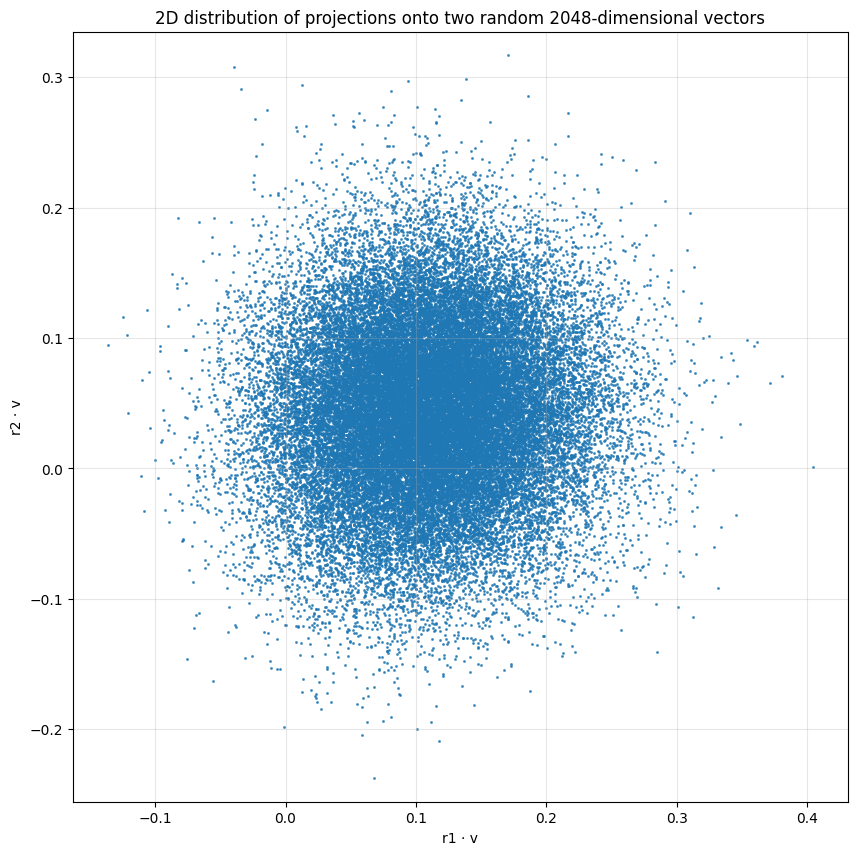

r1 · v - Mean: 0.1095, Std: 0.0620
r2 · v - Mean: 0.0442, Std: 0.0647


In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
r1 = np.random.randn(2048)
r1 = r1 / np.linalg.norm(r1)

r2 = np.random.randn(2048)
r2 = r2 / np.linalg.norm(r2)



print("r:", r1[:10])
print("r:", r2[:10])

projections1 = layer_data @ r1
projections2 = layer_data @ r2

plt.figure(figsize=(10, 10))
plt.scatter(projections1, projections2, alpha=0.5, s=1)
plt.xlabel('r1 · v')
plt.ylabel('r2 · v')
plt.title('2D distribution of projections onto two random 2048-dimensional vectors')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

print(f"r1 · v - Mean: {projections1.mean():.4f}, Std: {projections1.std():.4f}")
print(f"r2 · v - Mean: {projections2.mean():.4f}, Std: {projections2.std():.4f}")

In [13]:
from data_analysis.shapiro import shapiro

metrics = shapiro(projections1.reshape(-1, 1))
print(metrics)






  Subsampling to 5000 samples and 1 features for testing
{'shapiro_p': 0.21668677003982106}
